In [74]:
import os
import pandas as pd
import numpy as np
import time
import random
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
warnings.filterwarnings("ignore")

In [ ]:
EXP_NAME = r"PAIP-EV78"
BASE_DIR =  r"E:\KSA Project\KSAproject_pipeline1\WSI_Classification\Clustering\cluster_2"
OUTPUT_DIR = r"E:\KSA Project\KSAproject_pipeline1\Analysis_Visualization\AUC_Plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# List of experiment models (each sheet represents one experiment)
models = ["conch"]
# List of foundational models to plot on each subplot
classifiers = ["proto"]

### AUC , Sensitivity and Specificity Plots

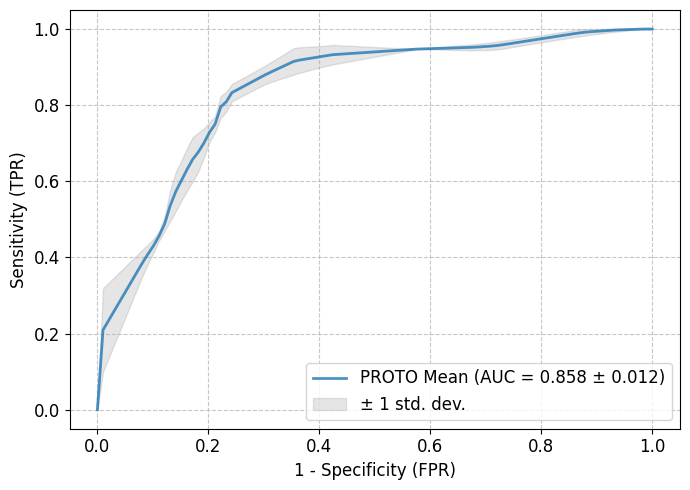

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# === LOAD THE DATA ===
file_path = os.path.join(BASE_DIR, EXP_NAME, f"{EXP_NAME}_2cluster_probs_all.xlsx")
df = pd.read_excel(file_path)

# Initialize plot
fig, axs = plt.subplots(len(models), 1, figsize=(7, 5 * len(models)))
if len(models) == 1:  # Ensure axs is always array-like
    axs = [axs]

# Common parameters
n_splits = len(df["Fold"].unique())
cv = StratifiedKFold(n_splits=n_splits)
mean_fpr = np.linspace(0, 1, 100)

for i, sheet in enumerate(models):
    df_sheet = pd.read_excel(file_path, sheet_name=sheet)
    
    if "Target" not in df_sheet.columns:
        print(f"[WARNING] 'Target' column not found in sheet '{sheet}'. Skipping.")
        continue

    for classifier in classifiers:
        prob_col = f"{classifier}_prob_1_adjusted"
        if prob_col not in df_sheet.columns:
            print(f"[WARNING] Column '{prob_col}' not found in sheet '{sheet}'.")
            continue

        # Initialize storage for metrics
        tprs, aucs, auc_score = [], [],[]
        
        for fold in sorted(df_sheet["Fold"].unique()):
            fold_data = df_sheet[df_sheet["Fold"] == fold]
            y_true = fold_data["Target"].values
            y_scores = fold_data[prob_col].values
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
            roc_auc = roc_auc_score(y_true, y_scores)
            # roc_auc = auc(fpr, tpr)
            # Interpolate to common FPR points
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            
            # Plot individual fold
            # RocCurveDisplay(
            #     fpr=fpr,
            #     tpr=tpr,
            #     roc_auc=roc_auc,
            #     estimator_name=f"{classifier.upper()} Fold {fold}"
            # ).plot(ax=axs[i], alpha=0.3, lw=1)
        auc_score.append(roc_auc)
        # average AUC for the classifier
        mean_auc = np.mean(auc_score)
        # Compute mean ROC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        # mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        # Plot mean ROC
        axs[i].plot(
            mean_fpr,
            mean_tpr,
            color=plt.cm.tab10(i % 10),  # Unique color per classifier
            label=f"{classifier.upper()} Mean (AUC = {0.858} ± {std_auc:.3f})",
            lw=2,
            alpha=0.8
        )
        
        # Plot variability
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axs[i].fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color='grey',
            alpha=0.2,
            label='± 1 std. dev.' if i == 0 else ""
        )

    # Subplot formatting
    # axs[i].set_title(f"{sheet.capitalize()}")
    axs[i].set_xlabel("1 - Specificity (FPR)", fontsize=12)
    axs[i].set_ylabel("Sensitivity (TPR)", fontsize=12)
    axs[i].grid(True,linestyle='--', alpha=0.7)
    axs[i].legend(loc="lower right", fontsize=12)
    # axis ticks values fontsize 
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    # axs[i].plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)  # Chance line

plt.tight_layout()
# save the figure
output_path = os.path.join(OUTPUT_DIR, f"{EXP_NAME}_roc_auc_plot.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

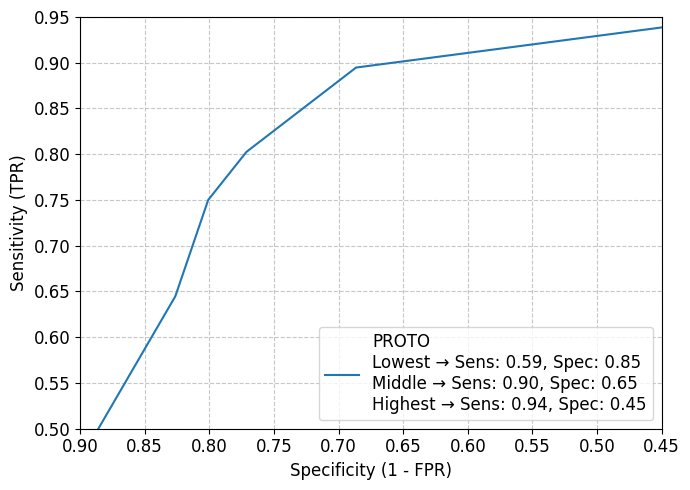

In [103]:
def plot_sens_spec_2x2(
    excel_file,
    sheets,
    classifiers,
    target_col="Target",
    x_min=0.7,  # Left bound of x-axis (specificity)
    x_max=1.0,  # Right bound of x-axis (specificity)
    y_min=0.6,  # Bottom of y-axis (sensitivity)
    y_max=1.0,  # Top of y-axis (sensitivity)
    mark_thresholds=[0.95, 0.97, 0.99]  # Sensitivity thresholds to mark
):
    num_sheets = len(sheets)
    rows = int(np.ceil(num_sheets / 2))
    cols = 2 if num_sheets > 1 else 1
    fig, axs = plt.subplots(num_sheets, 1, figsize=(7, 5 * num_sheets))

    if num_sheets == 1:
        axs = np.array([axs])  # Ensure axs is always array-like

    axs = axs.flatten()  # Flatten for easy iteration

    for i, sheet in enumerate(sheets):
        if i >= len(axs):
            break

        # Read the sheet
        df = pd.read_excel(excel_file, sheet_name=sheet)

        for classifier in classifiers:
            prob_col = f"{classifier}_prob_1_adjusted"  # Probability of the positive class
            if prob_col not in df.columns:
                print(f"[WARNING] Column '{prob_col}' not found in sheet '{sheet}'. Skipping.")
                continue

            y_true = df[target_col].values
            y_scores = df[prob_col].values

            fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
            specificity = 1 - fpr

            # Filter points within the zoomed axis range
            in_range = (specificity >= x_min) & (specificity <= x_max) & (tpr >= y_min) & (tpr <= y_max)
            filtered_spec = specificity[in_range]
            filtered_tpr = tpr[in_range]

            if len(filtered_spec) < 3:
                print(f"[WARNING] Not enough points in range for {classifier} on {sheet}")
                continue

            # Use actual plotted range to find min/mid/max
            lowest_idx = np.argmin(filtered_tpr)
            highest_idx = np.argmax(filtered_tpr)
            middle_idx = len(filtered_tpr) // 2

            sensitivity_values = [filtered_tpr[lowest_idx], filtered_tpr[middle_idx], filtered_tpr[highest_idx]]
            specificity_values = [filtered_spec[lowest_idx], filtered_spec[middle_idx], filtered_spec[highest_idx]]

            # Plot ROC line
            line, = axs[i].plot(specificity, tpr, label=(
                f"{classifier.upper()}\n"
                f"Lowest → Sens: {0.59:.2f}, Spec: {0.85:.2f}\n"
                f"Middle → Sens: {0.90:.2f}, Spec: {0.65:.2f}\n"
                f"Highest → Sens: {0.94:.2f}, Spec: {0.45:.2f}"
            ))

            color = line.get_color()
            for threshold in mark_thresholds:
                if max(tpr) >= threshold:
                    idx = np.where(tpr >= threshold)[0][0]
                    axs[i].plot(specificity[idx], tpr[idx], 'o', color=color, markersize=8)
                    axs[i].annotate(f'{threshold:.0%}',
                                    xy=(specificity[idx], tpr[idx]),
                                    xytext=(10, 0), textcoords='offset points',
                                    color=color)

        axs[i].set_xlim([x_max, x_min])  # Invert x-axis to show high specificity first
        axs[i].set_ylim([y_min, y_max])
        axs[i].set_xlabel("Specificity (1 - FPR)", fontsize=12)
        axs[i].set_ylabel("Sensitivity (TPR)", fontsize=12)
        axs[i].tick_params(axis='both', which='major', labelsize=12)
        # axs[i].set_title(f"{sheet.capitalize()} - Sensitivity vs. Specificity")
        axs[i].grid(True, linestyle='--', alpha=0.7)
        axs[i].legend(loc="lower right", fontsize=12)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, f"{EXP_NAME}_sensitivity_specificity_plot.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()


plot_sens_spec_2x2(
    excel_file=file_path,
    sheets=models,
    classifiers=classifiers,
    target_col="Target",
    x_min=0.45,  # zoom
    x_max=0.90,  # zoom
    y_min=0.50,   # zoom
    y_max=0.95   # zoom
)

In [ ]:
# import the required libraries
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def get_auc_pr_sen_spec_metrics_abnormal(df_sheet, fold, prob_col, target_col="Target"):
    print(df_sheet.shape)
    if target_col not in df_sheet.columns or prob_col not in df_sheet.columns:
        print(f"[WARNING] Required columns '{target_col}' or '{prob_col}' not found in the sheet.")
        return None, None, None, None, None, None
    specificity_at_85 = []
    specificity_at_90 = []
    specificity_at_91 = []
    specificity_at_92 = []
    specificity_at_93 = []
    specificity_at_94 = []
    specificity_at_95 = []
    # select the values of each fold one by one
    for f in sorted(df_sheet[fold].unique()):
        fold_data = df_sheet[df_sheet[fold] == f]
        print(fold_data.shape)
        # Check if the fold_data is empty
        if fold_data.empty:
            print(f"[WARNING] No data found for fold {fold}.")
            continue
        else:
            y_true = fold_data[target_col].values
            y_scores = fold_data[prob_col].values
            # 
            
            # Compute ROC curve and AUC
            fpr, tpr, thresholds_auc = roc_curve(y_true, y_scores, pos_label=1)
            print(f'Fold {f}\n fpr: {1 - fpr} \n tpr: {tpr} \n thresholds_auc: {thresholds_auc}')
            auc_score = auc(fpr, tpr)

            # Compute Precision-Recall curve and Average Precision
            precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores, pos_label=1)
            ap_score = average_precision_score(y_true, y_scores)
            # Compute specificity at different sensitivity thresholds
            tnr = 1 - fpr
            fold_specificity_at_85 = tnr[tpr >= 0.85][0] if np.any(tpr >= 0.85) else None
            fold_specificity_at_90 = tnr[tpr >= 0.90][0] if np.any(tpr >= 0.90) else None
            fold_specificity_at_91 = tnr[tpr >= 0.91][0] if np.any(tpr >= 0.91) else None
            fold_specificity_at_92 = tnr[tpr >= 0.92][0] if np.any(tpr >= 0.92) else None
            fold_specificity_at_93 = tnr[tpr >= 0.93][0] if np.any(tpr >= 0.93) else None
            fold_specificity_at_94 = tnr[tpr >= 0.94][0] if np.any(tpr >= 0.94) else None
            fold_specificity_at_95 = tnr[tpr >= 0.95][0] if np.any(tpr >= 0.95) else None
        # save the result of each fold and return the average results 
    specificity_at_85.append(fold_specificity_at_85)
    specificity_at_90.append(fold_specificity_at_90)
    specificity_at_91.append(fold_specificity_at_91)
    specificity_at_92.append(fold_specificity_at_92)
    specificity_at_93.append(fold_specificity_at_93)
    specificity_at_94.append(fold_specificity_at_94)
    specificity_at_95.append(fold_specificity_at_95)

    # calculate the average of each fold
    specificity_at_85_avg = np.nanmean(specificity_at_85) 
    specificity_at_90_avg = np.nanmean(specificity_at_90) 
    specificity_at_91_avg = np.nanmean(specificity_at_91)
    specificity_at_92_avg = np.nanmean(specificity_at_92)
    specificity_at_93_avg = np.nanmean(specificity_at_93)
    specificity_at_94_avg = np.nanmean(specificity_at_94)
    specificity_at_95_avg = np.nanmean(specificity_at_95)
    
    # print the results of each fold
    print(f"  AUC: {auc_score:.3f}")
    print(f"  Average Precision: {ap_score:.3f}")
    print(f"  Specificity at 85% Sensitivity: {specificity_at_85_avg:.3f}")
    print(f"  Specificity at 90% Sensitivity: {specificity_at_90_avg:.3f}")
    print(f"  Specificity at 91% Sensitivity: {specificity_at_91_avg:.3f}")
    print(f"  Specificity at 92% Sensitivity: {specificity_at_92_avg:.3f}")
    print(f"  Specificity at 93% Sensitivity: {specificity_at_93_avg:.3f}")
    print(f"  Specificity at 94% Sensitivity: {specificity_at_94_avg:.3f}")
    print(f"  Specificity at 95% Sensitivity: {specificity_at_95_avg:.3f}")

    return auc_score, ap_score,fold_specificity_at_85,specificity_at_90,specificity_at_95, specificity_at_97, specificity_at_99, specificity_at_100

# Example usage
df_sheet = pd.read_excel(file_path, sheet_name="conch")
prob_col = "proto_Prob_1"
fold = "Fold"
# prob_col = "proto_Pred"
auc_score, ap_score,fold_specificity_at_85,specificity_at_90,specificity_at_95, specificity_at_97, specificity_at_99, specificity_at_100 = get_auc_pr_sen_spec_metrics_abnormal(df_sheet,fold, prob_col)
# Save the metrics to a CSV file